In [1]:
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
plt.rcParams['savefig.facecolor']='white'
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [3]:
# get the right red/blue shades
#red_rgb = [103,0,31] # edges of RdBu
#blue_rgb = [5,48,97] # edges of RdBu
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255
alpha = .2 # transparency inside boxplots, for datapts etc.

# vid names as saved in behavioral data
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", 
            "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]

In [4]:
#loading shen atlas labels
pd.set_option('display.max_colwidth', None) # so columns are not snipped
# loading the Shen atlas labels
shen268_lbl = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268_lbl.head()
# to print an ROI: eval(shen268[str(insert ROI val between 1-268)][0])['name']

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
0,"{'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}","{'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}","{'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}","{'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}","{'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}","{'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}","{'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}","{'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}","{'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}","{'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}",...,"{'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}","{'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}","{'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}","{'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}","{'coords': [-4.68474576271187, -10.2406779661017, 5.877966101694909], 'name': '82.71% Left_Thalamus; 13.90% Left_Lateral_Ventrical'}","{'coords': [-11.407792207792212, -25.563636363636363, 14.883116883116884], 'name': '61.82% Left_Thalamus; 31.43% Left_Lateral_Ventrical'}","{'coords': [-4.821052631578951, -21.51157894736842, -15.890526315789472], 'name': '71.16% Brain-Stem; 25.89% no_label'}","{'coords': [-4.227272727272734, -37.89772727272728, -53.26704545454545], 'name': '100.00% Brain-Stem'}","{'coords': [-6.9375, -33.13068181818181, -39.34659090909091], 'name': '99.15% Brain-Stem'}","{'coords': [-5.697885196374628, -18.966767371601208, -36.81570996978852], 'name': '100.00% Brain-Stem'}"


In [5]:
#suff= ''
suff = '_corrected'

In [9]:
# load responses (nsubs * nmovies, values 0 for "no", 1 for "yes", "9" for unsure )
responses = np.load(os.path.join(data_file_loc,f'responses{suff}.npy'))
responses.shape
# note for me: even though data extraction was wrong in the iniital version (e.g. when a "coaxing" response was missed, the other responses were pushed up), 
# we end up excluding these subs anyway  in the pre-processing because their RT is retained and shows up as 0 - so we end up getting only good subs for this 
# analysis even in the early wrong analysis

(1049, 10)

In [7]:
tr0_ind = 3 # ind at which tr=0 starts
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)

tr_compensate = 1 # move TR back and low-level regs forward, change to 0 for what we had before
if vid_start_rel_tr[0]==7:
    vid_start_rel_tr -= 1 # vid_start_rel_tr stored are the first timepts AFTER t=0 (these were created for regressors originally, so without subtracting 1, each index
# we get (7, 14 etc.) was when the first nonzero regressor value was to be assigned)
# so without subtracting 1, we could potentially have been losing the earliest TR (check preprocess step 1_1 to verify)

print(vid_start_rel_tr)
l_task = 28

def remove_pretrial_TRs(tcs,vid_start_rel_tr,pretrial_TRs):
    # remove unnecessary BOLD timepts (everything not in the range [-3:28])
    tcs1 = np.empty((tcs.shape[0],tcs.shape[1],28+pretrial_TRs,tcs.shape[3]))
    tcs1[:] = np.nan
    for vid_no in range(10):
        tr0 = vid_start_rel_tr[vid_no]
        tcs1[:,:,:,vid_no] = tcs[:,:,tr0-pretrial_TRs:tr0+28,vid_no] # 31 timepts
    return tcs1

[6 13 13 13 13 6 13 13 13 13]


In [8]:
# COAX-BILL
#select subs who responded "Social" to COAXING-B and "Non-social" to BILLIARD-A
print('\nTrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm{suff}.npy')
tcs_trial_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_trial_z.shape)
tcs_trial_z = remove_pretrial_TRs(tcs_trial_z,vid_start_rel_tr,tr0_ind) # remove unwanted timepts from the fixtion blocks
print('after:',tcs_trial_z.shape)

movie_ind_yes = 0 # CHANGE MOVIE IND HERE - "Social"
movie_ind_no = 1 # CHANGE MOVIE IND HERE - "Non-social"
print('"Social" movie: ' + str(vidnames[movie_ind_yes]))
print('"Non-social" movie: ' + str(vidnames[movie_ind_no]))


Trial-wise norm data.
before: (1049, 268, 56, 10)
after: (1049, 268, 31, 10)
"Social" movie: COAXING-B
"Non-social" movie: BILLIARD-A


(1049, 268, 31, 10)

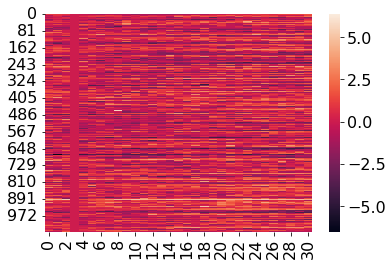

In [9]:
tcs_trial_z[0,0,:,0]
# if it's the 5th index that is 0, that means baseline correction was wrong. it should've been the 4th index. let's correct this/
sns.heatmap(tcs_trial_z[:,0,:,0])
tcs_trial_z.shape

In [10]:
tcs_trial_z[0,0,:,0]

array([ 8.36913044e-01, -1.72085122e-01,  9.61529177e-01,  0.00000000e+00,
        4.28501664e-01, -7.87436833e-01,  1.23349112e+00,  2.17973539e-01,
       -5.87104829e-02,  2.44418963e-01,  2.26580217e+00, -1.13760816e-01,
        2.31573522e+00, -3.95495047e-01,  1.69716421e+00,  1.04487085e+00,
        1.83837416e+00,  3.31780764e+00, -1.19928012e-03,  1.98937958e+00,
        1.90178369e+00,  2.86383879e+00,  1.66729706e+00, -1.17062201e+00,
        1.05268416e+00,  1.74081933e+00,  1.43224651e+00,  2.13956308e+00,
        1.01311653e+00,  1.39794846e+00,  1.99354807e+00])

<AxesSubplot:>

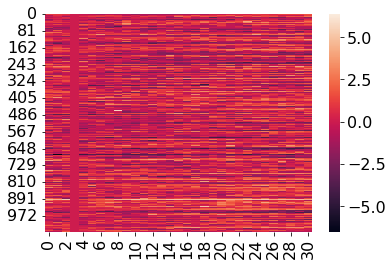

In [11]:
if tr_compensate==1:
    if len(np.where(tcs_trial_z[:,0,tr0_ind+1,0]==0)[0]) == tcs_trial_z.shape[0]:
        print('in')
        for s in range(tcs_trial_z.shape[0]):
            for n in range(tcs_trial_z.shape[1]):
                for m in range(10):
                    tcs_trial_z[s,n,:,m]  = tcs_trial_z[s,n,:,m] - tcs_trial_z[s,n,tr0_ind,m]
sns.heatmap(tcs_trial_z[:,0,:,0])

In [12]:
import time
from joblib import cpu_count
from pymer4.models import Lmer,Lm
from multiprocessing import Pool
from sklearn.linear_model import LinearRegression
from joblib import Parallel,delayed

In [13]:
#subs who respondec "Social" to COAXING-B and "Non-social" to BILLIARD-A
subs = np.where((responses[:,movie_ind_yes] == 1)&(responses[:,movie_ind_no] == 0))[0] 
nsubs = np.where(subs)[0].shape[0]
subs.shape, nsubs

((870,), 870)

In [14]:
def paired_ttest_across_time(tcs_trial_z_node):
    # perform an unpaired t-test at each node and timept for a selected movie (rand here)
    meandiff_soc_nonsoc, pval_soc_nonsoc = [np.empty((31)) for _ in range(2)]
    meandiff_soc_nonsoc[:], pval_soc_nonsoc[:] = [np.nan]*2   
    movie_ind_yes,movie_ind_no = 0,1
    for timept in np.arange(tr0_ind+1,tcs_trial_z_node.shape[1]):
        y1,y2 = tcs_trial_z_node[:,timept,movie_ind_yes],tcs_trial_z_node[:,timept,movie_ind_no]
        #if timept == tr0_ind+1:
        #    print(y1,y2)
        try:
            _,pval_soc_nonsoc[timept] = stats.ttest_rel(y1,y2,nan_policy='omit')
            meandiff_soc_nonsoc[timept] = np.nanmean(y1-y2)      
        except:
            pval_soc_nonsoc[timept] = np.nan
            meandiff_soc_nonsoc[timept] = np.nan     
    return pval_soc_nonsoc,meandiff_soc_nonsoc

# test above function
n=0
paired_ttest_across_time(tcs_trial_z[subs,n,:,:])

(array([           nan,            nan,            nan,            nan,
        8.39595563e-01, 7.89820444e-01, 2.15230542e-01, 1.41539239e-01,
        1.87221485e-01, 1.91055742e-02, 3.08862756e-02, 2.99819066e-01,
        5.00341061e-02, 2.64802434e-05, 2.13497586e-02, 1.85257018e-03,
        2.44455772e-03, 4.88846795e-02, 6.98426671e-02, 3.87389143e-01,
        3.12232489e-01, 1.57784027e-02, 2.82584947e-01, 9.86409338e-01,
        2.73984951e-01, 1.83029996e-02, 3.30439638e-01, 1.68492742e-01,
        1.48943567e-01, 6.82634243e-01, 4.04090777e-01]),
 array([        nan,         nan,         nan,         nan, -0.01149751,
        -0.0160108 , -0.07868126, -0.09598114, -0.08268252, -0.15069766,
        -0.13723056, -0.06716502, -0.12492609, -0.27959984, -0.15838979,
        -0.20612534, -0.20956724, -0.12923025, -0.12508801, -0.0613756 ,
        -0.07067311, -0.16736875, -0.0736911 , -0.00117799, -0.07488177,
        -0.16563032, -0.06910561, -0.09623164, -0.10062291, -0.02919547,


In [15]:
parallelise = 0

In [16]:
if tr_compensate==1:
    early_late = 'early'
else:
    early_late = 'late'
print(early_late)

early


In [17]:
early_late

'early'

<AxesSubplot:title={'center':'Mean difference per node and timepoint'}>

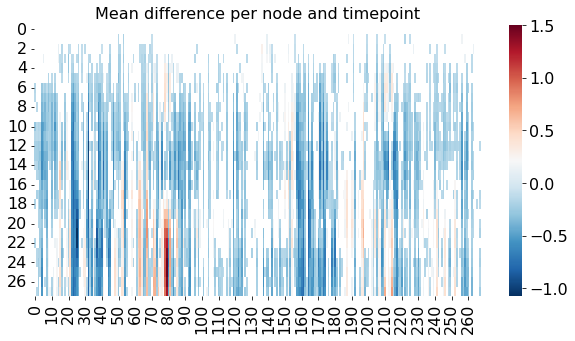

In [48]:
load = 1
#if __name__ == '__main__':
#   pool = Pool(processes=cpu_count()) # helps to parallelize processing
plt.figure(1,figsize=(10,5))
#if load ==0:
if parallelise:
    tcs_node_list = [tcs_trial_z[subs,n,:,:] for n in range(268)] # 15 secs per timept so that'll be 15*28 ~= 450s for all?
    #pval_meandiff_soc_nonsoc_coaxbill = pool.map(paired_ttest_across_time,tcs_node_list) 
    pval_meandiff_soc_nonsoc_coaxbill = Parallel(n_jobs=10)(delayed(paired_ttest_across_time)(y) for y in tcs_node_list) 

else:
    pval_meandiff_soc_nonsoc_coaxbill = []
    for n in range(268):
        #if n%10 ==0:
            #print(n)
        pval_meandiff_soc_nonsoc_coaxbill.append(paired_ttest_across_time(tcs_trial_z[subs,n,:,:]))

np.save(os.path.join(data_file_loc,f'coefs_pvals_alltimepts_COAXBILL_{early_late}.npy'), pval_meandiff_soc_nonsoc_coaxbill)
#else:
    #pval_meandiff_soc_nonsoc_coaxbill = np.load(os.path.join(data_file_loc,'coefs_pvals_alltimepts_COAXBILL.npy'))

meanDiff_coaxbill =  np.empty((268,31))
meanDiff_coaxbill[:] = np.nan
for n in range(268):
    pval_, meanDiff_ = pval_meandiff_soc_nonsoc_coaxbill[n] # 31 timepts
    meanDiff_coaxbill[n,pval_<.05] = meanDiff_[pval_<.05]
plt.title('Mean difference per node and timepoint')
sns.heatmap(meanDiff_coaxbill[:,tr0_ind:].T,cmap='RdBu_r')

In [50]:
tr_compensate

1

In [51]:
z_score=1
#if tr_compensate == 1:
resid_tc = np.load(os.path.join(data_file_loc,'residuals_tc_z_trialwise_earlyTR.npy'))
#else:
#    resid_tc = np.load(os.path.join(data_file_loc,'residuals_tc_z_trialwise_lateTR.npy'))
#if z_score==1:
#else:
#    resid_tc = np.load(os.path.join(data_file_loc,'residuals_tc.npy'))
resid_tc.shape,resid_tc[0,:2,:,0]

((1049, 268, 31, 2),
 array([[ 0.83691304, -0.17208512,  0.96152918,  0.        ,  0.42850166,
         -0.78743683,  1.23350382,  0.21843582, -0.05434533,  0.26266688,
          2.31023339, -0.04003535,  2.40877029, -0.29777618,  1.7869808 ,
          1.12522038,  1.91990455,  3.40973811,  0.10574118,  2.12340827,
          2.09107391,  3.1388382 ,  2.03049371, -0.75184971,  1.47638697,
          2.118102  ,  1.71641695,  2.28560397,  0.99403189,  1.22803504,
          1.72831163],
        [ 0.10752508,  1.43104672,  0.21644018,  0.        ,  2.22176398,
          0.10019237,  1.37656396,  1.40719806, -0.059071  ,  1.36962841,
          1.17772107,  1.5963565 ,  0.22381827,  0.80375962,  0.73107172,
          2.2554663 ,  2.8794806 ,  2.05613059,  1.7668573 ,  2.18452719,
          1.65281431,  2.88058348, -0.26607939,  0.98514276,  1.05432491,
          0.5188913 ,  3.72787815,  1.07469623,  1.35165127,  1.70285451,
          0.77907174]]))

In [52]:
stats.ttest_rel(resid_tc[subs,n,tr0_ind+1,0],resid_tc[subs,n,tr0_ind+1,1],nan_policy='omit')

Ttest_relResult(statistic=-0.8304880330290058, pvalue=0.40649101290459566)

<AxesSubplot:title={'center':'Mean difference per node and timepoint (resid)'}>

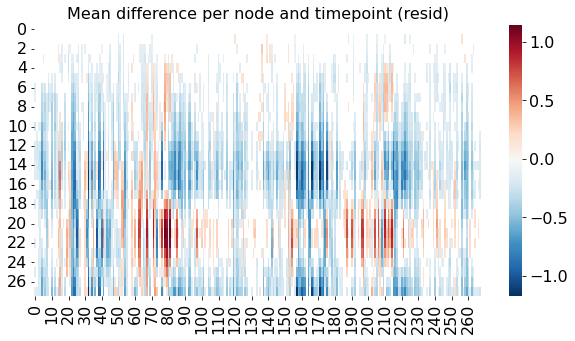

In [53]:
# residuals' analysis
load= 0
plt.figure(1,figsize=(10,5))
#if load == 0:
if parallelise:
    resid_tc_list = [resid_tc[subs,n,:,:] for n in range(268)] # 15 secs per timept so that'll be 15*28 ~= 450s for all?
    #pval_meandiff_soc_nonsoc_coaxbill_resid = pool.map(paired_ttest_across_time,resid_tc_list)#tcs_node_list) 
    pval_meandiff_soc_nonsoc_coaxbill_resid = Parallel(n_jobs=10)(delayed(paired_ttest_across_time)(y) for y in resid_tc_list) 
else:
    pval_meandiff_soc_nonsoc_coaxbill_resid = []
    for n in range(268):
        #if n%10 ==0:
            #print(n)
        pval_meandiff_soc_nonsoc_coaxbill_resid.append(paired_ttest_across_time(resid_tc[subs,n,:,:]))

np.save(os.path.join(data_file_loc,f'coefs_pvals_alltimepts_COAXBILL_resid_{early_late}.npy'), pval_meandiff_soc_nonsoc_coaxbill_resid)
#else:
#    pval_meandiff_soc_nonsoc_coaxbill_resid = np.load(os.path.join(data_file_loc,'coefs_pvals_alltimepts_COAXBILL_resid.npy'))
    
meanDiff_coaxbill_resid =  np.empty((268,31))
meanDiff_coaxbill_resid[:] = np.nan
for n in range(268):
    pval_resid, meanDiff_resid = pval_meandiff_soc_nonsoc_coaxbill_resid[n]
    meanDiff_coaxbill_resid[n,pval_resid<.05] = meanDiff_resid[pval_resid<.05]
plt.title('Mean difference per node and timepoint (resid)')
sns.heatmap(meanDiff_coaxbill_resid[:,tr0_ind:].T,cmap='RdBu_r')

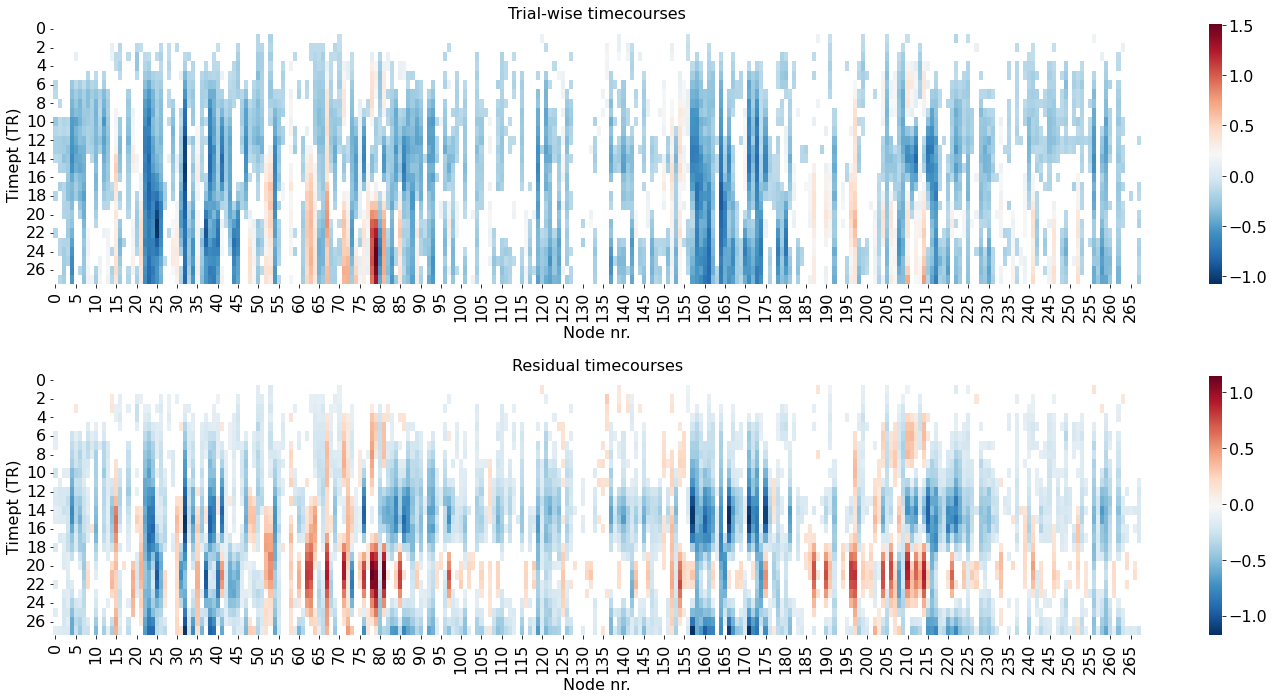

In [54]:
plt.figure(1,figsize=(20,10))
plt.subplot(211)
plt.title('Trial-wise timecourses')
sns.heatmap(meanDiff_coaxbill[:,tr0_ind:].T,cmap='RdBu_r')
plt.xlabel('Node nr.')
plt.ylabel('Timept (TR)')
plt.subplot(212)
plt.title('Residual timecourses')
sns.heatmap(meanDiff_coaxbill_resid[:,tr0_ind:].T,cmap='RdBu_r')
plt.xlabel('Node nr.')
plt.ylabel('Timept (TR)')

plt.tight_layout()


In [55]:
# get earliest pt of divergence COAX-BILL

#if load == 0:
earliest_pt_coaxbill, sign_earliest_pt_coaxbill = [np.empty((268,)) for _ in range(2)]
earliest_pt_coaxbill[:], sign_earliest_pt_coaxbill[:] = [np.nan]*2
for n in np.arange(0,268): # np.arange(10):
    sig_timepts =  np.where(~np.isnan(meanDiff_coaxbill[n,:]))[0]
    for t in sig_timepts:
        if t < 30:
            if (t+1) in sig_timepts: #(pval_auc<.05) and ( ( ((t-1) in sig_timepts) or ((t+1) in sig_timepts) ) and (np.sign(meandiff_auc) == np.sign(meanDiff_rand[n,t])):# and (t_array[0][i+1] - t_array[0][i] == 1):
                earliest_pt_coaxbill[n]      = t #subtract by 3 in brainmaps!!
                sign_earliest_pt_coaxbill[n] = np.sign(meanDiff_coaxbill[n,t])
                break             

#if load == 0:
earliest_pt_coaxbill_resid, sign_earliest_pt_coaxbill_resid = [np.empty((268,)) for _ in range(2)]
earliest_pt_coaxbill_resid[:], sign_earliest_pt_coaxbill_resid[:] = [np.nan]*2
for n in np.arange(0,268): # np.arange(10):
    sig_timepts_resid =  np.where(~np.isnan(meanDiff_coaxbill_resid[n,:]))[0]
    for t in sig_timepts_resid:
        if t < 30:
            if (t+1) in sig_timepts_resid:
                earliest_pt_coaxbill_resid[n]      = t #subtract by 3 in brainmaps!!
                sign_earliest_pt_coaxbill_resid[n] = np.sign(meanDiff_coaxbill_resid[n,t])
                break

In [56]:
movie_ind_yes,movie_ind_no

(0, 1)

In [57]:
# get a variable storing whether nodes show a difference in the end
#if load ==0:
end_diff_coaxbill,   sign_end_diff_coaxbill,    end_diff_coaxbill_resid,    sign_end_diff_coaxbill_resid    = \
[np.empty((268,)) for _ in range(4)]
end_diff_coaxbill[:],sign_end_diff_coaxbill[:], end_diff_coaxbill_resid[:], sign_end_diff_coaxbill_resid[:] = [np.nan]*4

for n in range(268):# np.arange(10):
    sig_timepts       =  np.where(~np.isnan(meanDiff_coaxbill[n,:]))[0]
    sig_timepts_resid =  np.where(~np.isnan(meanDiff_coaxbill_resid[n,:]))[0]
    
    if len(sig_timepts) > 2: # no pt doing this if there aren't at least 2 sig pts
        tcn1 = np.nanmean(tcs_trial_z[subs,n,-2:,movie_ind_yes],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
        tcn2 = np.nanmean(tcs_trial_z[subs,n,-2:,movie_ind_no],axis=1)
        _,pval_end = stats.ttest_rel(tcn1,tcn2,nan_policy='omit')
        meandiff_end = np.nanmean(tcn1 - tcn2)
        if pval_end < .05:
            end_diff_coaxbill[n],sign_end_diff_coaxbill[n] = 1,np.sign(meandiff_end)
    
    if len(sig_timepts_resid) > 2: # no pt doing this if there aren't at least 2 sig pts
        tcn1 = np.nanmean(resid_tc[subs,n,-2:,movie_ind_yes],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
        tcn2 = np.nanmean(resid_tc[subs,n,-2:,movie_ind_no],axis=1)
        _,pval_end = stats.ttest_rel(tcn1,tcn2,nan_policy='omit')
        meandiff_end_resid = np.nanmean(tcn1 - tcn2) 
        if pval_end < .05:
            end_diff_coaxbill_resid[n],sign_end_diff_coaxbill_resid[n] = 1,np.sign(meandiff_end_resid)

In [58]:
#if tr_compensate==1:
early_late = 'early'
#else:
#    early_late = 'late'
#print(early_late)

In [58]:
load = 1 # CHANGE HERE IF NEEDED.
if load: # load LME coefs
    [earliest_pt_coaxbill,sign_earliest_pt_coaxbill]= np.load(os.path.join(data_file_loc,f'earliest_pt_div_coaxbill_{early_late}.npy'))
    [end_diff_coaxbill,sign_end_diff_coaxbill]= np.load(os.path.join(data_file_loc,f'end_pt_div_coaxbill_{early_late}.npy'))
    [earliest_pt_coaxbill_resid,sign_earliest_pt_coaxbill_resid] = np.load(os.path.join(data_file_loc,f'earliest_pt_div_coaxbill_resid_{early_late}.npy'))
    [end_diff_coaxbill_resid,sign_end_diff_coaxbill_resid] = np.load(os.path.join(data_file_loc,f'end_pt_div_coaxbill_resid_{early_late}.npy'))
else:
    np.save(os.path.join(data_file_loc,f'earliest_pt_div_coaxbill_{early_late}.npy'),       [earliest_pt_coaxbill,sign_earliest_pt_coaxbill])
    np.save(os.path.join(data_file_loc,f'end_pt_div_coaxbill_{early_late}.npy'),            [end_diff_coaxbill,sign_end_diff_coaxbill])
    np.save(os.path.join(data_file_loc,f'earliest_pt_div_coaxbill_resid_{early_late}.npy'), [earliest_pt_coaxbill_resid,sign_earliest_pt_coaxbill_resid])
    np.save(os.path.join(data_file_loc,f'end_pt_div_coaxbill_resid_{early_late}.npy'),      [end_diff_coaxbill_resid,sign_end_diff_coaxbill_resid])

In [60]:
#  coax-bill
# plot timecourses with all timepts of divergences
plot_all=0
if plot_all:
    ncols,nrows = 6,int(np.ceil(268/ncols))
    xwidth,yheight = 20,100# .75*nrows*xwidth/ncols
    fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize = (xwidth,yheight))
    fig.set_figwidth(xwidth)
    fig.set_figheight(yheight)

    x_ticks = np.round(np.linspace(0,30,4),2)  
    ymin,ymax = -.5,2
    lbls = [str(i-tr0_ind) for i in x_ticks]
    movie_ind = 4
    for n in range(268):
        movieTC_yes = tcs_trial_z[subs,n,:,myes] # nsubs * ntimepts
        movieTC_no  = tcs_trial_z[subs,n,:,mno] # nsubs * ntimepts
        r = int(np.floor(n/ncols))
        c = int(np.floor(n%ncols))
        ax[r,c].errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_yes,axis=0),stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = red_rgb,linewidth=2,label ='"Social"')
        ax[r,c].errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_no,axis=0),stats.sem(movieTC_no,axis=0,nan_policy='omit'),color = blue_rgb,linewidth=2,label ='Non-social"')
        ax[r,c].vlines(tr0_ind,ymin,ymax,color='grey')
        ax[r,c].hlines(0,0,31,color='grey')
        sig = np.where(~np.isnan(meanDiff_coaxbill[n,:]))[0]
        ax[r,c].plot(sig,np.repeat(1.7,len(sig)),color = 'grey',ls = 'None',marker = '*',label ="p<.05unc.")
        ax[r,c].plot(earliest_pt_coaxbill[n],1.9,color = 'k',ls = 'None',marker = 'v',mfc='k',markersize = 8,label = "earliest p<.05unc.")
        if end_diff_coaxbill[n] == 1:
            ax[r,c].plot([29,30],[1.5,1.5],color = 'k',ls = 'None',marker = '^',mfc='k',markersize=8,label ='end-pts. p<.05unc.') # earliest_pt still in the 3-31 range
        ax[r,c].set_title(f'Node {n+1}')
        if n == 5:
            ax[r,c].legend(bbox_to_anchor=[1.05,1])
        #ax[r,c].vlines(earliest_pt_all[n],ymin,ymax,color = 'k')
        ax[r,c].set_xticks(x_ticks)
        ax[r,c].set_xticklabels(lbls)
    ax[r,c+1].axis('off')
    ax[r,c+2].axis('off')
    plt.tight_layout()

In [61]:
earliest_pt_coaxbill_corrected = earliest_pt_coaxbill - tr0_ind
earliest_pt_coaxbill_corrected_resid = earliest_pt_coaxbill_resid - tr0_ind
#earliest_pt_coaxbill_corrected,earliest_pt_coaxbill_corrected_resid

(array([28., 56., 50., 28., 25., 28., 22.,  2.,  6.,  9.]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <BarContainer object of 10 artists>)

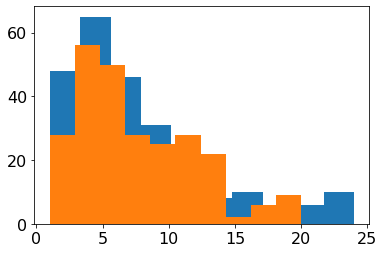

In [62]:
plt.hist(earliest_pt_coaxbill_corrected)
plt.hist(earliest_pt_coaxbill_corrected_resid)

# Plot brainmaps

In [63]:
fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig5_timecourse/')

In [2]:
#import plotting functions

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
#from nilearn.plotting import plot_glass_brain,plot_stat_map,plot_surf,view_img_on_surf,plot_img
from nilearn.plotting import plot_surf_roi, plot_img, plot_surf_contours,view_surf
from nilearn import datasets,surface,image
import nibabel as nib

#import nilearn
#nilearn.__version__ # .7.0 in py37 env

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

fsaverage = datasets.fetch_surf_fsaverage()

shen268_lbl = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
#shen268_lbl

bg_img = datasets.load_mni152_template()

lbl = [str.upper(x[0:4]) for x in vidnames]
lbl

NameError: name 'vidnames' is not defined

In [14]:
test_surf_plot.axes[1]

<Axes:label='<colorbar>'>

[0.  0.5 1.  1.5 2. ]


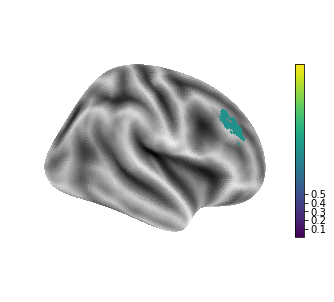

In [18]:
num_nodes =  268 # shen atlas
test_node = np.zeros((num_nodes,))
test_node[10] = 1

texture = surface.vol_to_surf(color_rois(test_node), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
test_surf_plot=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = 'viridis', colorbar=True,
                            threshold=.01, bg_map=fsaverage.sulc_right,symmetric_cbar = False)
tks = test_surf_plot.axes[1].get_yticks()
print(tks)
test_surf_plot.axes[1].set_yticks([.1,.2,.3,.4,.5])

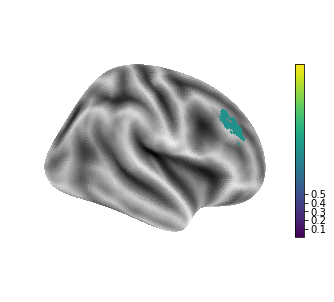

In [17]:

test_surf_plot

In [19]:
# for comparison with the other main figure if needed
nodes_coaxbill_rand_all = np.load(os.path.join(data_file_loc,'nodes_coaxbill_rand_all.npy')) # sig nodes hihglighted in the first S>NS GLM
len(np.where(nodes_coaxbill_rand_all)[0])

70

In [4]:
def color_rois(values):
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    shen268 = nib.load(os.path.join(data_file_loc,"shen_2mm_268_parcellation.nii.gz"))
    shen268_data = shen268.get_fdata()
    img = np.zeros(shen268_data.shape)
    #print(shen268_data.shape)
    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        #print(len(itemindex[0]))
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii


In [21]:
#coords = [10*int(i) for i in np.linspace(-4,7,6)]
coords = [-40,-25,-10,0,10,25,40,60]
TR=.72
time_units = 'sec' # 'sec','TR'
log_scale = 1
cmap ='viridis'
# present all results in seconds

In [22]:
v5_roi = 'v5_association-test_z_FDR_0.01.nii'
v5_roi_loc = f'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/ROIs/{v5_roi}'
v5_roi_nii = nib.load(v5_roi_loc)

psts_roi = 'psts_association-test_z_FDR_0.01.nii'
psts_roi_loc = f'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/ROIs/{psts_roi}'
psts_roi_nii = nib.load(psts_roi_loc)

(10242, 227, 5.505677219492696, 3.734893426946704)

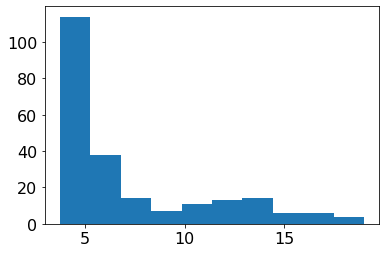

In [23]:
texture = surface.vol_to_surf(v5_roi_nii,                          fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
thr99 = np.quantile(texture,.99)

plt.hist(texture[texture!=0])
len(texture),len(np.where(texture!=0)[0]),thr99,min(texture[texture!=0])

In [24]:
# COAX-BILL, surface p[ot
def surfplotL_COAXBILL(earliest_pt_coaxbill_corrected, ax1,ax2,scale_type='log',dat_type='resid',max_TR = 5):
    #max_TR = 5
    nodes = np.zeros((268,))
    #nodes_ind = (end_diff_coaxbill==1) & nodes_coaxbill_rand_all
    nodes_ind = nodes_coaxbill_rand_all    
    nodes[nodes_ind] = np.log(earliest_pt_coaxbill_corrected[nodes_ind]*TR)
    vmin,vmax = np.log(.72),np.log(np.round(max_TR*.72))
    
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin, axes=ax1,
                                threshold=.01, bg_map=fsaverage.sulc_left,symmetric_cbar = False)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin, axes=ax2,
                                threshold=.01, bg_map=fsaverage.sulc_left,symmetric_cbar = False,view='medial')#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
   
    #title_txt = '(a) COAX-BILL'
    #surf_plot1.axes[0].set_title(title_txt,fontsize=20,color='k')
    # add contour
    texture = surface.vol_to_surf(color_rois(nodes_coaxbill_rand_all), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    
    '''v5_texture = surface.vol_to_surf(v5_roi_nii,                          fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    thr99 = np.quantile(v5_texture,.99)
    v5_texture[v5_texture<thr99] = 0
    v5_texture[v5_texture!=0] = 1
    plot_surf_contours(fsaverage.infl_left, v5_texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['r'])#,levels = [texture],  labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_left, v5_texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['r'])#,levels = [texture],  labels=['Fig 3 nodes'])
    
    psts_texture = surface.vol_to_surf(psts_roi_nii,                          fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    thr99 = np.quantile(psts_texture,.99)
    psts_texture[psts_texture<thr99] = 0
    psts_texture[psts_texture!=0] = 1
    plot_surf_contours(fsaverage.infl_left, psts_texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['r'])#,levels = [texture],  labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_left, psts_texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['r'])#,levels = [texture],  labels=['Fig 3 nodes'])
    '''

def surfplotR_COAXBILL(earliest_pt_coaxbill_corrected, ax1,ax2,subplot_num=2,scale_type='log',dat_type = 'resid',max_TR=5):
    # right
    #max_TR = 5
    nodes = np.zeros((268,))
    #nodes_ind = (end_diff_coaxbill==1) & nodes_coaxbill_rand_all
    nodes_ind = nodes_coaxbill_rand_all
    
    nodes[nodes_ind] = np.log(earliest_pt_coaxbill_corrected[nodes_ind]*TR)
    vmin,vmax = np.log(.72),np.log(np.round(max_TR*.72))
    
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin,
                                threshold=.01, bg_map=fsaverage.sulc_right,symmetric_cbar = False,axes = ax1, view='medial')
    surf_plot2=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True, vmax = vmax,vmin=vmin,
                                threshold=.01, bg_map=fsaverage.sulc_right,symmetric_cbar = False,axes = ax2)
    tks = surf_plot2.axes[subplot_num].get_yticks()
    #tklabels = [.72,5,10,15,20]
    if scale_type == 'log':
        #tks = np.log(tklabels)
        tklabels = [np.round(i,1) for i in np.exp(tks)]
    elif scale_type == 'linear':
        #tks = tklabels
        tklabels = [np.round(i,1) for i in tks]
    
    surf_plot2.axes[subplot_num].set_yticklabels(tklabels,fontsize=24)
    surf_plot2.axes[subplot_num].text(8,2,s='  Divergence\n  point (s,\n  log scale)',fontsize=24, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})

    # add contour

    '''v5_texture = surface.vol_to_surf(v5_roi_nii, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    thr99 = np.quantile(v5_texture,.99)
    v5_texture[v5_texture<thr99] = 0
    v5_texture[v5_texture!=0] = 1
    plot_surf_contours(fsaverage.infl_right, v5_texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['r'])#,levels = [nodes_coaxbill_rand_all], , labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_right, v5_texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['r'])#,labels=['V5(top 1%vox)'])#,levels = [nodes_coaxbill_rand_all], , labels=['Fig 3 nodes'])
    
    psts_texture = surface.vol_to_surf(psts_roi_nii, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    thr99 = np.quantile(psts_texture,.99)
    psts_texture[psts_texture<thr99] = 0
    psts_texture[psts_texture!=0] = 1
    plot_surf_contours(fsaverage.infl_right, psts_texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['r'])#,levels = [nodes_coaxbill_rand_all], , labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_right, psts_texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['r'])#,labels=['V5(top 1%vox)'])#,levels = [nodes_coaxbill_rand_all], , labels=['Fig 3 nodes'])
    '''
    
 
    texture = surface.vol_to_surf(color_rois(nodes_coaxbill_rand_all), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['k'])#,labels=['GLM analysis nodes'])#,levels = [nodes_coaxbill_rand_all], , labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['k'])#,levels = [nodes_coaxbill_rand_all], , labels=['Fig 3 nodes'])

# COAX-BILL, axial p[ot
def axplot_COAXBILL(earliest_pt_coaxbill_corrected,fig,ax,scale_type='log',dat_type='resid',max_TR = 5):
    nodes = np.zeros((268,))
    #nodes_ind = (end_diff_coaxbill==1) & nodes_coaxbill_rand_all
    nodes_ind = nodes_coaxbill_rand_all    
    nodes[nodes_ind] = np.log(earliest_pt_coaxbill_corrected[nodes_ind]*TR)
    vmin,vmax = np.log(.72),np.log(np.round(max_TR*.72))
    img = roi_to_brain(pd.Series(nodes), mask_x)
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, figure=fig,
    cut_coords = coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001,axes=ax)
    
    '''ax_plot.add_contours(color_rois((nodes_coaxbill_rand_all)),linewidths=.5, colors='k',linestyles='solid')
    texture = surface.vol_to_surf(v5_roi_nii, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    thr99 = np.quantile(texture,.99)
    v5_roi_nii_copy = image.threshold_img(v5_roi_nii, thr99)
    ax_plot.add_contours(v5_roi_nii_copy,linewidths=.5, colors='r',linestyles='solid')'''


In [115]:
[[n,eval(shen268_lbl[str(n+1)][0])['name']] for n in range(268) if 'frontal_pole' in str.lower(eval(shen268_lbl[str(136+1)][0])['name'])]

[[0, '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'],
 [1, '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'],
 [2, '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'],
 [3, '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'],
 [4,
  '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'],
 [5, '100.00% Frontal_Pole'],
 [6, '100.00% Frontal_Pole'],
 [7, '99.85% Frontal_Pole'],
 [8, '100.00% Frontal_Pole'],
 [9,
  '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'],
 [10, '52.15% Frontal_Pole; 47.85% Middle_Frontal_Gyrus'],
 [11, '56.57% Superior_Frontal_Gyrus; 41.14% Frontal_Pole'],
 [12,
  '33.82% Middle_Frontal_Gyrus; 33.82% Frontal_Pole; 26.94% Superior_Frontal_Gyrus; 5.42% no_label'],
 [13, '98.80% Middle_Frontal_Gyrus'],
 [14, '58.36% Cingulate_Gyrus_anterior_division; 41.00% Paracingulate_Gyrus'],
 [15,
  '42.87% Inferior_Frontal_Gyrus_pars_triangularis; 25.98% I

In [37]:
np.where(nodes_coaxbill_rand_all)[0].shape

(70,)

(0.0, 2.0)

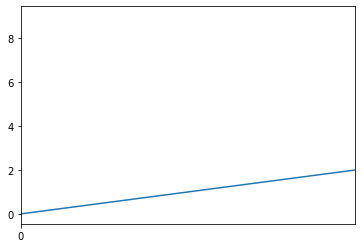

In [22]:
plt.plot(range(10), range(10))
plt.xticks(np.arange(0,10.1,5))
plt.xlim([0,2])

In [69]:
for n in range(134):
    if nodes_coaxbill_rand_all[n] and (earliest_pt_coaxbill_resid[n] > 12)  and (eval(shen268_lbl[str(n+1)][0])['coords'][2]<-15)\
        and (eval(shen268_lbl[str(n+1)][0])['coords'][2]>-40):
        print(n,earliest_pt_coaxbill_resid[n], eval(shen268_lbl[str(n+1)][0])['coords'],eval(shen268_lbl[str(n+1)][0])['name'])

116 23.0 [7.242424242424249, -53.7030303030303, -34.333333333333336] 87.58% no_label; 12.42% Brain-Stem
118 17.0 [30.309322033898304, -36.39830508474576, -31.093220338983052] 49.05% no_label; 27.70% Temporal_Fusiform_Cortex_posterior_division; 10.78% Brain-Stem; 8.67% Temporal_Occipital_Fusiform_Cortex


Right
Node (1-268): 119 [30.309322033898304, -36.39830508474576, -31.093220338983052] 49.05% no_label; 27.70% Temporal_Fusiform_Cortex_posterior_division; 10.78% Brain-Stem; 8.67% Temporal_Occipital_Fusiform_Cortex


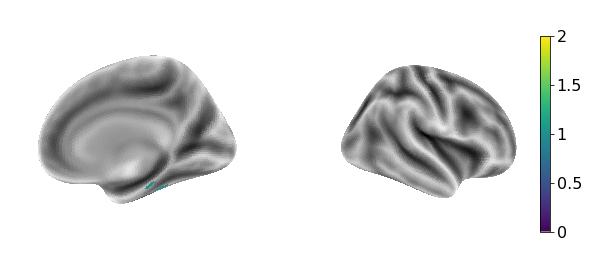

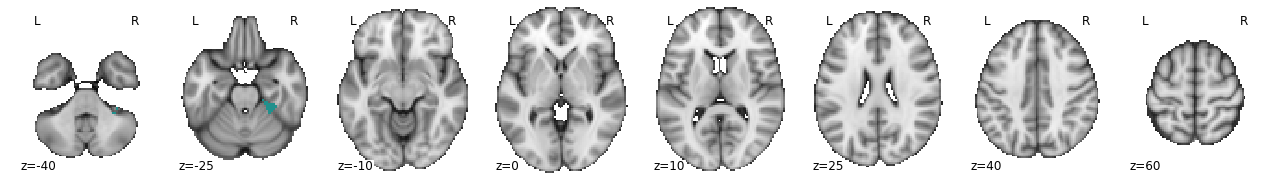

In [71]:
nodes = np.zeros((268,))
n=118
#print(eval(shen268_lbl[str(n+1)][0])['name'])
nodes[n] = 1 
vmin = 0
vmax=2
fig,ax = plt.subplots(nrows=1, ncols= 2,figsize=(10,6),subplot_kw={'projection': '3d'})
ax1 = ax[0]
ax2 = ax[1]
if n > 133:
    print("Left")
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)

    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin,
                                threshold=.01, bg_map=fsaverage.sulc_left,symmetric_cbar = False,axes = ax1, view='medial')

    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=True, vmax = vmax,vmin=vmin,
                                threshold=.01, bg_map=fsaverage.sulc_left,symmetric_cbar = False,axes = ax2)
else:
    print("Right")
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)

    surf_plot1=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin,
                                threshold=.01, bg_map=fsaverage.sulc_right,symmetric_cbar = False,axes = ax1, view='medial')
    surf_plot2=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True, vmax = vmax,vmin=vmin,
                                threshold=.01, bg_map=fsaverage.sulc_right,symmetric_cbar = False,axes = ax2)
img = roi_to_brain(pd.Series(nodes), mask_x)
ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax,
cut_coords = coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
print('Node (1-268):',n+1, eval(shen268_lbl[str(n+1)][0])['coords'],eval(shen268_lbl[str(n+1)][0])['name'])


In [100]:
np.where((earliest_pt_coaxbill_corrected_resid==1) & (nodes_coaxbill_rand_all))

(array([ 70, 156, 191, 199, 205]),)

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/ma/core.py:2830: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


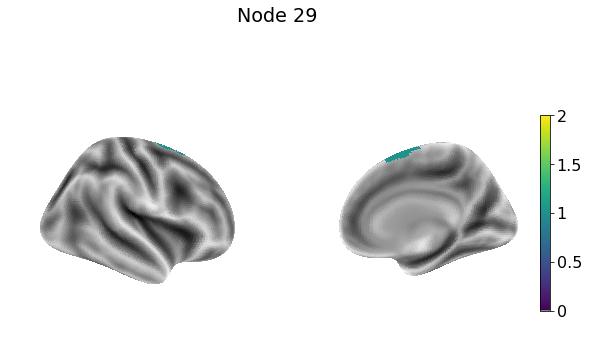

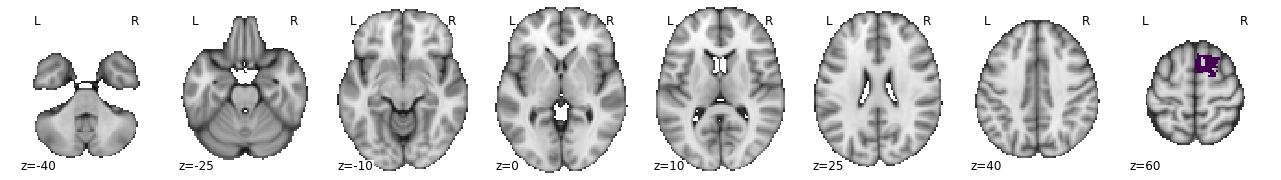

In [81]:
nodes = np.zeros((268,))
#nodes[:]=np.nan
n=28
nodes[n] =1
fig,ax = plt.subplots(nrows=1, ncols= 2,figsize=(10,6),subplot_kw={'projection': '3d'})
max_TR = 1
if n > 134:
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, axes=ax[0],
                                threshold=.01,  bg_map=fsaverage.sulc_left,symmetric_cbar = False)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=True, axes=ax[1],
                                threshold=.01, vmax=2, bg_map=fsaverage.sulc_left,symmetric_cbar = False,view='medial')#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
else:
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False, axes=ax[0],
                            threshold=.01,  bg_map=fsaverage.sulc_right,symmetric_cbar = False)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    surf_plot2=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True, axes=ax[1],
                            threshold=.01, vmax=2, bg_map=fsaverage.sulc_right,symmetric_cbar = False,view='medial')#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})

plt.suptitle(f"Node {n+1}")
img = roi_to_brain(pd.Series(nodes), mask_x)
plot_img(img.to_nifti(), display_mode = 'z', 
cut_coords = coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)

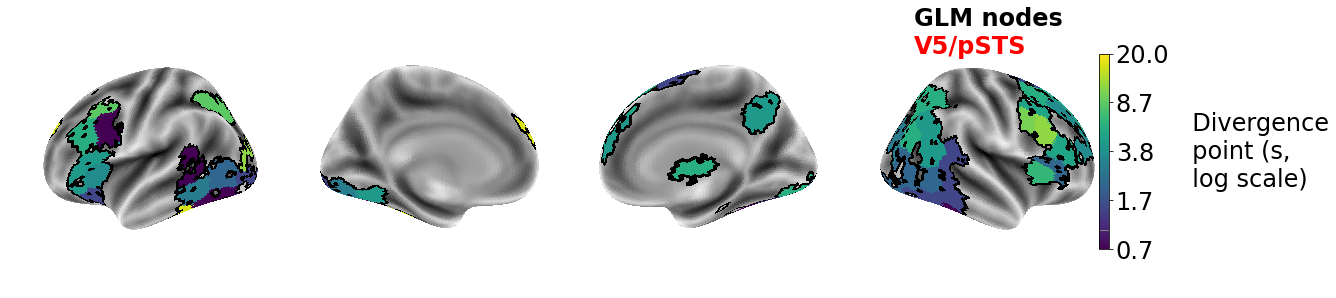

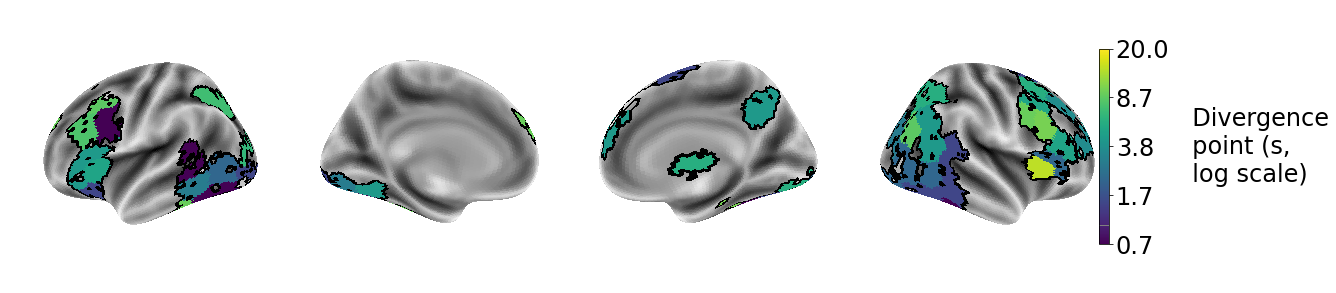

In [82]:
# surface plots
early_late = 'early'

fig,ax = plt.subplots(nrows=1, ncols= 4,figsize=(20,6),subplot_kw={'projection': '3d'})
max_TR = 28
#plt.suptitle('BOLD COAX["Social"]-BILL["Non-social"]',fontsize=24,fontweight='bold')
#ax[0].annotate('BOLD COAX-BILL',fontsize=24,fontweight='bold',xy=(.05,.85), xycoords='axes fraction')
surfplotL_COAXBILL(earliest_pt_coaxbill_corrected,ax[0],ax[1],scale_type='log',dat_type='resid',max_TR =max_TR)
subplot_num = 4
surfplotR_COAXBILL(earliest_pt_coaxbill_corrected, ax[2],ax[3],subplot_num,scale_type='log',dat_type='resid',max_TR = max_TR)
ax[3].annotate('GLM nodes', xy=(.25,.95), xycoords='axes fraction',fontsize = 24,fontweight='bold')
ax[3].annotate('V5/pSTS', xy=(.25,.85), xycoords='axes fraction', color='r',fontsize = 24,fontweight='bold')
plt.subplots_adjust(wspace=0.001)
plt.savefig(os.path.join(fig_save_loc,f'coaxbill/surfplot_both_hem_maxTR{max_TR}_{early_late}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

fig,ax = plt.subplots(nrows=1, ncols= 4,figsize=(20,6),subplot_kw={'projection': '3d'})
max_TR = 28
#plt.suptitle('Residual COAX["Social"]-BILL["Non-social"]',fontsize=24,fontweight='bold')
#ax[0].annotate('Residual COAX-BILL',fontsize=24,fontweight='bold',xy=(.05,.85), xycoords='axes fraction')
surfplotL_COAXBILL(earliest_pt_coaxbill_corrected_resid,ax[0],ax[1],scale_type='log',dat_type='resid',max_TR =max_TR)
subplot_num = 4
surfplotR_COAXBILL(earliest_pt_coaxbill_corrected_resid, ax[2],ax[3],subplot_num,scale_type='log',dat_type='resid',max_TR = max_TR)
plt.subplots_adjust(wspace=0.001)
plt.savefig(os.path.join(fig_save_loc,f'coaxbill/surfplot_both_hem_maxTR{max_TR}_resid_{early_late}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

In [84]:
coords

[-40, -25, -10, 0, 10, 25, 40, 60]

In [86]:
len(np.where(nodes_coaxbill_rand_all)[0])

70

(array([ 50,  53,  70, 139, 156, 191, 199, 205]),)

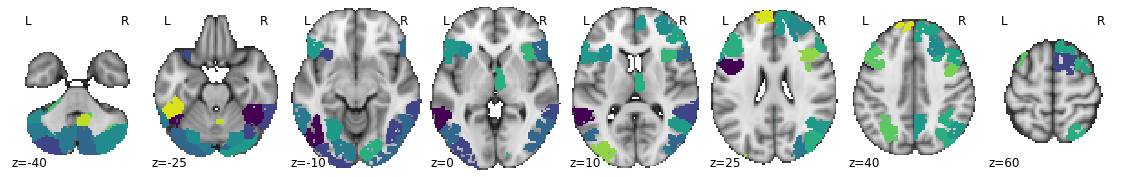

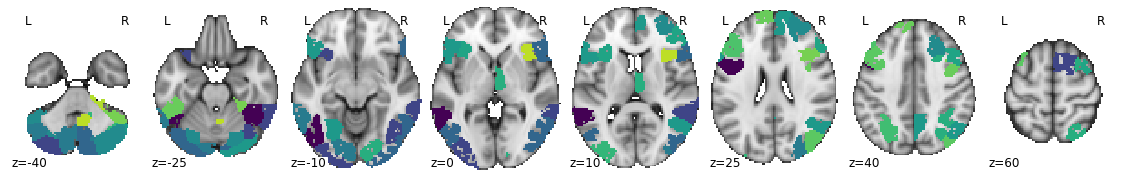

In [83]:
# axial plot
max_TR = 28
fig,ax = plt.subplots(nrows=1, ncols= 1,figsize=(20,3))
axplot_COAXBILL(earliest_pt_coaxbill_corrected,scale_type='log',dat_type='resid',max_TR = max_TR, fig=fig,ax=ax)
plt.savefig(os.path.join(fig_save_loc,f'coaxbill/axial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

# axial plot
fig,ax = plt.subplots(nrows=1, ncols= 1,figsize=(20,3))
axplot_COAXBILL(earliest_pt_coaxbill_corrected_resid,scale_type='log',dat_type='resid',max_TR = max_TR,fig=fig,ax=ax)
plt.savefig(os.path.join(fig_save_loc,f'coaxbill/axial_resid.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

In [81]:
# COAX-BILL, surface p[ot
def view_surfplot_COAXBILL(earliest_pt_coaxbill_corrected, max_TR = 5):
    #max_TR = 5
    nodes = np.zeros((268,))
    nodes_ind = nodes_coaxbill_rand_all    
    #nodes[nodes_ind] = np.log(earliest_pt_coaxbill_corrected[nodes_ind]*TR)
    #vmin,vmax = np.log(.72),np.log(np.round(max_TR*.72))
    nodes[nodes_ind] = earliest_pt_coaxbill_corrected[nodes_ind]*TR
    vmin,vmax = .72,np.round(max_TR*.72)
    v5_texture = surface.vol_to_surf(v5_roi_nii, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    thr99 = np.quantile(v5_texture,.99)
    v5_texture[v5_texture<thr99] = 0
    v5_texture[v5_texture!=0] = 1
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    vsurf_plot1=view_surf(fsaverage.infl_left, texture,cmap = cmap, colorbar=True, vmax = vmax,
                            threshold=.01, bg_map=fsaverage.sulc_left,symmetric_cmap = False)        
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    vsurf_plot2=view_surf(fsaverage.infl_right, texture,cmap = cmap, colorbar=True, vmax = vmax,
                            threshold=.01, bg_map=fsaverage.sulc_right,symmetric_cmap = False)
    
    return vsurf_plot1, vsurf_plot2

vsurf_plot1, vsurf_plot2 = view_surfplot_COAXBILL(earliest_pt_coaxbill_corrected,max_TR)
flname = os.path.join(fig_save_loc,f'coaxbill/view_surfplot_maxTR{max_TR}_Left.html')
vsurf_plot1.save_as_html(flname)

flname = os.path.join(fig_save_loc,f'coaxbill/view_surfplot_maxTR{max_TR}_Right.html')
vsurf_plot2.save_as_html(flname)

vsurf_plot1, vsurf_plot2 = view_surfplot_COAXBILL(earliest_pt_coaxbill_corrected_resid,max_TR)
flname = os.path.join(fig_save_loc,f'coaxbill/view_surfplot_maxTR{max_TR}_Left_resid.html')
vsurf_plot1.save_as_html(flname)
flname = os.path.join(fig_save_loc,f'coaxbill/view_surfplot_maxTR{max_TR}_Right_resid.html')
vsurf_plot2.save_as_html(flname)

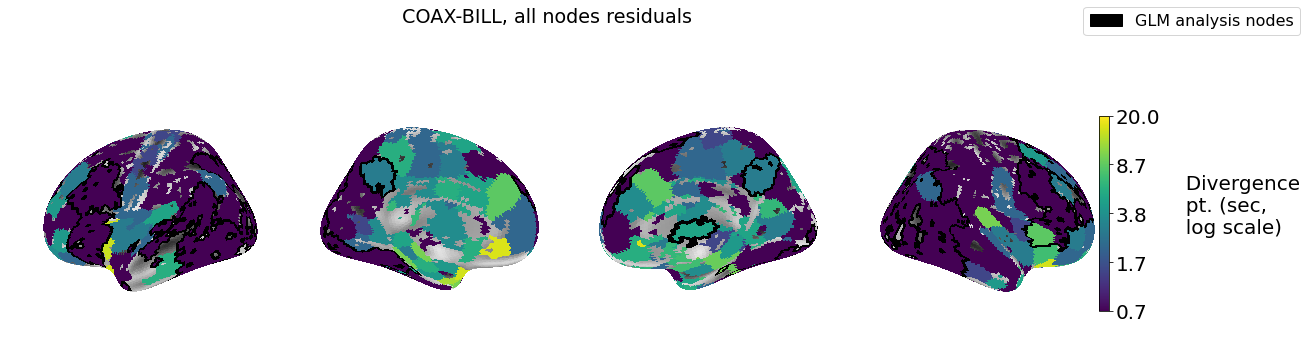

In [73]:
# COAX-BILL, all nodes

def surfplotL_COAXBILL_allnodes(earliest_pt_coaxbill_corrected, ax1,ax2,scale_type='log',max_TR = 5):
    
    nodes = np.zeros((268,))
        nodes_ind = nodes_coaxbill_rand_all!=10
    if scale_type == 'log':
        nodes[nodes_ind] = np.log(earliest_pt_coaxbill_corrected[nodes_ind]*TR)
        #nodes[end_diff_all_nocoaxbill==1] = np.log(earliest_pt_all_corrected_nocoaxbill[end_diff_all_nocoaxbill==1] * TR)
        vmin,vmax = np.log(.72),np.log(np.round(max_TR*.72))
    
    elif scale_type == 'linear':
        nodes[nodes_ind] = earliest_pt_coaxbill_corrected[nodes_ind]*TR
        vmin,vmax = .72,np.round(max_TR*.72)
    
    else:
        raise Exception('correct scale_type!')
    
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    #texture = surface.vol_to_surf(color_rois(log_nodes_all_nocoaxbill), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin, axes=ax1,
                                threshold=.01, bg_map=fsaverage.sulc_left,symmetric_cbar = False)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin, axes=ax2,
                                threshold=.01, bg_map=fsaverage.sulc_left,symmetric_cbar = False,view='medial')#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
   
    #title_txt = '(a) COAX-BILL'
    #surf_plot1.axes[0].set_title(title_txt,fontsize=20,color='k')
    # add contour
    texture = surface.vol_to_surf(color_rois(nodes_coaxbill_rand_all), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    #plt.savefig(os.path.join(fig_save_loc,'coaxbill/surfplot_LH.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

def surfplotR_COAXBILL_allnodes(earliest_pt_coaxbill_corrected, ax1,ax2,subplot_num=2,scale_type='log',dat_type = 'resid',max_TR = 5):
    # right
    nodes = np.zeros((268,))
    '''if dat_type == 'not_resid': 
        nodes_ind = (end_diff_coaxbill==1) & nodes_coaxbill_rand_all
    elif dat_type == 'resid':
        nodes_ind = nodes_coaxbill_rand_all'''
    nodes_ind = nodes_coaxbill_rand_all!=10
    if scale_type == 'log':
        nodes[nodes_ind] = np.log(earliest_pt_coaxbill_corrected[nodes_ind]*TR)
        #nodes[end_diff_all_nocoaxbill==1] = np.log(earliest_pt_all_corrected_nocoaxbill[end_diff_all_nocoaxbill==1] * TR)
        vmin,vmax = np.log(.72),np.log(np.round(max_TR*.72))
    elif scale_type == 'linear':
        nodes[nodes_ind] = earliest_pt_coaxbill_corrected[nodes_ind]*TR
        vmin,vmax = .72,np.round(max_TR*.72)
    else:
        raise Exception('correct scale_type!')
    
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin,
                                threshold=.01, bg_map=fsaverage.sulc_right,symmetric_cbar = False,axes = ax1, view='medial')
    surf_plot2=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True, vmax = vmax,vmin=vmin,
                                threshold=.01, bg_map=fsaverage.sulc_right,symmetric_cbar = False,axes = ax2)
    tks = surf_plot2.axes[subplot_num].get_yticks()
    #tklabels = [.72,5,10,15,20]
    if scale_type == 'log':
        #tks = np.log(tklabels)
        tklabels = [np.round(i,1) for i in np.exp(tks)]
    elif scale_type == 'linear':
        #tks = tklabels
        tklabels = [np.round(i,1) for i in tks]
    
    surf_plot2.axes[subplot_num].set_yticklabels(tklabels,fontsize=20)
    surf_plot2.axes[subplot_num].text(25,2,s='  Divergence\n  pt. (sec,\n  log scale)',fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})

    # add contour
    texture = surface.vol_to_surf(color_rois(nodes_coaxbill_rand_all), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['k'])#,levels = [nodes_coaxbill_rand_all], , labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot2, legend=True, axes=ax2,levels=[1],colors=['k'],labels=['GLM analysis nodes'])#,levels = [nodes_coaxbill_rand_all], , labels=['Fig 3 nodes'])
    #return surf_plot2

max_TR = 28
fig,ax = plt.subplots(nrows=1, ncols= 4,figsize=(20,6),subplot_kw={'projection': '3d'})
plt.suptitle('COAX-BILL, all nodes residuals')
surfplotL_COAXBILL_allnodes(earliest_pt_coaxbill_corrected_resid,ax[0],ax[1],scale_type='log',dat_type='resid',max_TR=max_TR)
subplot_num = 4
surfplotR_COAXBILL_allnodes(earliest_pt_coaxbill_corrected_resid,ax[2],ax[3],subplot_num,scale_type='log',dat_type='resid',max_TR=max_TR)
plt.subplots_adjust(wspace=0.001)
plt.savefig(os.path.join(fig_save_loc,'coaxbill/surfplot_both_hem_resid_nofilter.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

saving fig 1 resid


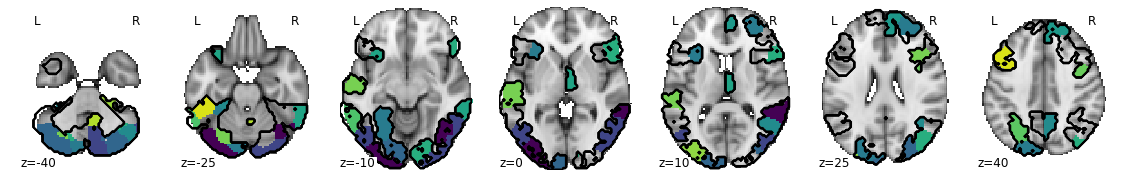

In [75]:
#plot earliest divergence point unsigned: COAX-BILL
txt = '  Timepoint (sec)\n  of earliest\n  divergence\n  (p<.05 unc.)'
def axplot_COAXBILL(earliest_pt_coaxbill_corrected,ax,scale_type = 'log',dat_type='resid',max_TR=5):

    nodes = np.zeros((268,))
    if dat_type == 'resid':
        nodes_ind = (end_diff_coaxbill==1) & nodes_coaxbill_rand_all
    elif dat_type=='not_resid':
        nodes_ind = nodes_coaxbill_rand_all     
     
    if scale_type == 'log':
        vmax = np.log(np.round(max_TR*.72))
        vmin = np.log(.72)
        nodes[nodes_ind] = np.log(earliest_pt_coaxbill_corrected[nodes_ind] * TR)
    elif scale_type == 'linear':
        vmax = np.round(max_TR*.72)
        vmin = .72
        nodes[nodes_ind] = earliest_pt_coaxbill_corrected[nodes_ind] * TR
    else:
        raise Exception('correct scale_type!')
    nodes[np.isnan(nodes)] = 0 # nan value would have been if there are nodes with end differences but no earliest timept divergence - doing this just to make all non-data values 0.

    #tks = surf_plot2.axes[subplot_num].get_yticks()
    #tklabels = [.72,5,10,15,20]
    #if scale_type == 'log':
        #tks = np.log(tklabels)
        #tklabels = [np.round(i,1) for i in np.exp(tks)]
    #elif scale_type == 'linear':
        #tks = tklabels
        #tklabels = [np.round(i,1) for i in tks]
    
    img = roi_to_brain(pd.Series(nodes), mask_x)
    if scale_type == 'log':
        ax_plot = plot_img(img.to_nifti(), display_mode = 'z',cut_coords =coords,cmap = cmap, vmin = vmin,vmax = vmax,bg_img = bg_img,colorbar= False,threshold = .01,axes=ax)
    elif scale_type == 'linear':
        ax_plot = plot_img(img.to_nifti(), display_mode = 'z',cut_coords =coords,cmap = cmap, vmin = vmin,vmax = vmax,bg_img = bg_img,colorbar= True,threshold = .01,axes=ax)
        ax_plot.title("COAX-BILL (linear scale)",fontsize=24,bgcolor='k',color='w',fontweight='bold')

    ax_plot.add_contours(color_rois(nodes_coaxbill_rand_all),linewidths=1, colors=['k'],linestyles='solid')
    #ax_plot._cbar.set_ticks(tks)
    #ax_plot._cbar.set_ticklabels(tklabels)
    #ax_plot._colorbar_ax.text(0.95,.8*vmax,txt,fontsize=20,fontdict = {'verticalalignment':'top','rotation':0})#get_legend()
    #plt.savefig(os.path.join(fig_save_loc,'all_except_coaxbill/earliestpt_unsigned_endsig_axial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')



saving fig 1 resid
saving fig 1 not_resid


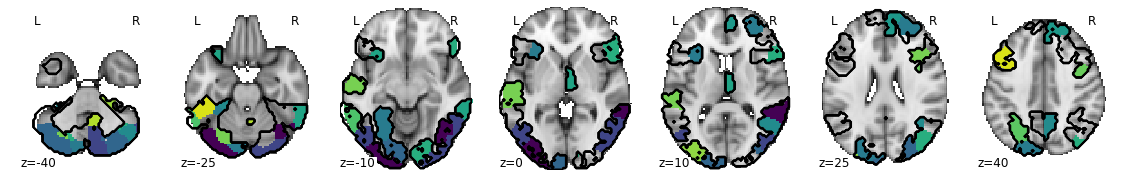

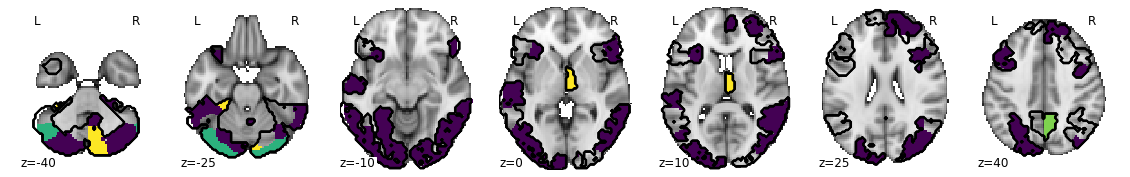

In [77]:
max_TR=28
coords = [-40,-25,-10,0,10,25,40]
for i,scale_type in enumerate(['log']):#,'linear']):
    #scale_type = 'log' # or 'linear
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,3))
    axplot_COAXBILL(earliest_pt_coaxbill_corrected,ax,scale_type,max_TR=max_TR)
    if scale_type == 'log':
        print('saving fig', log_scale, 'resid')
        plt.savefig(os.path.join(fig_save_loc,'coaxbill/earliestpt_unsigned_endsig_axial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
        
coords = [-40,-25,-10,0,10,25,40]
for i,scale_type in enumerate(['log']):#,'linear']):
    #scale_type = 'log' # or 'linear
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,3))
    axplot_COAXBILL(earliest_pt_coaxbill_corrected_resid,ax,scale_type)
    if scale_type == 'log':
        print('saving fig', log_scale, 'not_resid')
        plt.savefig(os.path.join(fig_save_loc,'coaxbill/earliestpt_unsigned_endsig_axial_resid.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')